# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описания тарифов:

**Тариф "Смарт":**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
    
**Тариф "Ультра":**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
**Примечание**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Принимаем, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Изучение данных

Откроем все предоставленные данные и изучим их содержимое.

Сначала загрузим все необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
sns.set()
%matplotlib inline

Сохраним датасеты в переменные:

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

Теперь откроем все датасеты по очереди и изучим их содержимое.

**Таблица calls:**

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**Таблица internet:**

In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


**Таблица messages:**

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**Таблица tariffs:**

In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Таблица users:**

In [11]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**Согласно документации:**

Таблица users (информация о пользователях):

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

Таблица calls (информация о звонках):

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Вывод:**

1. Обнаружены пропуски в таблице users, в столбце churn_date.
2. Тип данных в столбцах с датами нужно поменять на date_time.

## Подготовка данных

### Таблица calls

Приведем тип данных в столбце call_date к типу datetime.

In [13]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

Проверим столбец duration:

In [14]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

В столбце есть значения, равные 0. Нам уже пояснили, что эти нулевые значения обозначают пропущенные звонки, потому удалять их мы не станем.

Округлим оставшиеся значения длительности звонков вверх:

In [15]:
calls['duration'] = np.ceil(calls['duration'])

Поскольку дробная часть уже не нужна, можно также поменять тип данных:

In [16]:
calls['duration'] = calls['duration'].astype(int)

### Таблица internet

Приведем тип данных в столбце session_date к типу datetime:

In [17]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Проверим столбец mb_used:

In [18]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Снова нулевые значения. Игнорируем их по тем же причинам, по которым мы игнорировали нулевые звонки.

Округлять мегабайты до целого числа мы пока не станем.

Нулевых интернет-сессий: 0.13 %


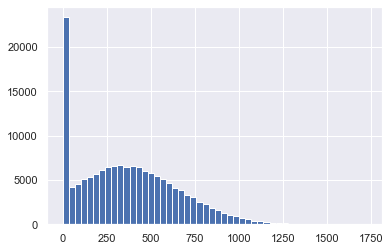

In [19]:
# Комментарий ревьюера 2
temp = internet.copy()
temp['mb_used'].hist(bins = 50)
print('Нулевых интернет-сессий:',round(temp['mb_used'].value_counts().sort_index()[0]/temp['mb_used'].count(),2), '%')

### Таблица messages

Приведем тип данных в столбце message_date к типу datetime:

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

### Таблица tariffs

В этой таблице ничего менять не нужно. Оставим все, как есть.

### Таблица users

NaN значения в churn_date говорят, что тариф для пользователя еще действовал на момент выгрузки. Посмотрим на количество таких пользователей.

In [21]:
print('Число пользователей, для которых дейcтвует тариф:', len(users[users.churn_date.isna()]))

Число пользователей, для которых дейcтвует тариф: 462


In [22]:
print('Число пользователей, для которых не дейcтвует тариф:', len(users[~users.churn_date.isna()]))

Число пользователей, для которых не дейcтвует тариф: 38


Приведем даты в churn_date к типу datetime:

In [23]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

Осталось только привести тип данных в столбце reg_date к datetime:

In [24]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

### Расчеты

Посчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя.

Сначала добавим в таблицы столбец с тарифом для каждого абонента. 

Для этого составим словарь с соответствием тарифа пользователю:

In [25]:
tarif_for_user = {}

Напишем функцию для заполнения этого словаря:

In [26]:
def add_tarif_to_user(row):
    tarif_for_user[row[0]] = row[7]

Применим функцию:

In [27]:
users.apply(add_tarif_to_user, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
495    None
496    None
497    None
498    None
499    None
Length: 500, dtype: object

Мы получили словарь, в котором для каждого user_id сопоставлен свой тариф. 

Добавим столбцы с тарифами к таблицам calls, internet и messages.

Для этого используем функцию:

In [28]:
def add_tariff(row):
    return tarif_for_user[row]

Применим ее:

In [29]:
for i in (calls, internet, messages):
    i['tariff'] = i['user_id'].apply(add_tariff)

Определим функцию, которая будет добавлять столбец с месяцем в таблицы:

In [30]:
def date_to_month(date, colname):
    date['month'] = date[colname].dt.month

Добавим стобец с номером месяца в наши таблицы:

In [31]:
for i in ((calls, 'call_date'), (internet, 'session_date'), (messages, 'message_date')):
    date_to_month(*i)

Рассчитаем звонки по месяцам для каждого пользователя:

In [32]:
calls_pivot = calls.pivot_table(index=['user_id', 'tariff', 'month'], values='duration', aggfunc=['sum', 'count'])
calls_pivot.columns = ['minutes_calls', 'count_calls']
calls_pivot.head(10)

minutes_calls  count_calls
user_id tariff month                            
1000    ultra  5                159           22
               6                172           43
               7                340           47
               8                408           52
               9                466           58
               10               350           57
               11               338           43
               12               333           46
1001    smart  11               430           59
               12               414           63

In [33]:
calls_pivot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 'ultra', 5) to (1499, 'smart', 12)
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   minutes_calls  3174 non-null   int32
 1   count_calls    3174 non-null   int64
dtypes: int32(1), int64(1)
memory usage: 53.7+ KB


Рассчитаем сообщения по месяцам для каждого пользователя:

In [34]:
messages_pivot = messages.pivot_table(index=['user_id', 'tariff', 'month'], values='id', aggfunc='count')
messages_pivot.columns = ['count_messages']
messages_pivot.head(10)

count_messages
user_id tariff month                
1000    ultra  5                  22
               6                  60
               7                  75
               8                  81
               9                  57
               10                 73
               11                 58
               12                 70
1002    smart  6                   4
               7                  11

In [35]:
messages_pivot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2717 entries, (1000, 'ultra', 5) to (1499, 'smart', 12)
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   count_messages  2717 non-null   int64
dtypes: int64(1)
memory usage: 35.4+ KB


Рассчитаем интернет-трафик по месяцам для каждого пользователя:

In [36]:
internet_pivot = internet.pivot_table(index=['user_id', 'tariff', 'month'], values='mb_used', aggfunc='sum')
internet_pivot.columns = ['gb_used']
internet_pivot.head(10)

gb_used
user_id tariff month          
1000    ultra  5       2253.49
               6      23233.77
               7      14003.64
               8      14055.93
               9      14568.91
               10     14702.49
               11     14756.47
               12      9817.61
1001    smart  11     18429.34
               12     14036.66

Значения в столбце gb_used записаны в мегабайтах. Округлим их до гигабайтов и отбросим нули:

In [37]:
internet_pivot['gb_used'] = np.ceil(internet_pivot['gb_used'] / 1024)
internet_pivot['gb_used'] = internet_pivot['gb_used'].astype(int)
internet_pivot.head(10)

gb_used
user_id tariff month         
1000    ultra  5            3
               6           23
               7           14
               8           14
               9           15
               10          15
               11          15
               12          10
1001    smart  11          18
               12          14

In [38]:
internet_pivot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, (1000, 'ultra', 5) to (1499, 'smart', 12)
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   gb_used  3203 non-null   int32
dtypes: int32(1)
memory usage: 29.2+ KB


Посчитаем выручку с каждого абонента. 

Для этого надо присоединить полученные таблицы к users:

In [39]:
data_merge = users.merge(calls_pivot.reset_index(), how='left').merge(internet_pivot.reset_index(), how='left').merge(messages_pivot.reset_index(), how='left')
data_merge.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_calls,count_calls,gb_used,count_messages
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,3.0,22.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,23.0,60.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,14.0,75.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,14.0,81.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,15.0,57.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,350.0,57.0,15.0,73.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,338.0,43.0,15.0,58.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,333.0,46.0,10.0,70.0
8,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,430.0,59.0,18.0,NaN
9,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,414.0,63.0,14.0,NaN


In [40]:
# Комментарий ревьюера
data_merge.user_id.unique().shape

(500,)

In [41]:
# Комментарий студента
len(data_merge['user_id'].unique())

500

In [42]:
# Комментарий ревьюера 2
temp = users.copy()
temp[(temp.user_id ==  1128) | (temp.user_id ==  1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Изучим новую таблицу повнимательнее:

In [43]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3182 non-null   int64         
 1   age             3182 non-null   int64         
 2   churn_date      189 non-null    datetime64[ns]
 3   city            3182 non-null   object        
 4   first_name      3182 non-null   object        
 5   last_name       3182 non-null   object        
 6   reg_date        3182 non-null   datetime64[ns]
 7   tariff          3182 non-null   object        
 8   month           3174 non-null   float64       
 9   minutes_calls   3174 non-null   float64       
 10  count_calls     3174 non-null   float64       
 11  gb_used         3163 non-null   float64       
 12  count_messages  2678 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 348.0+ KB


Обработаем пропуски. Учтем тот факт, что некоторые пользователи не использовали некоторые виды связи. Если в ячейке есть nan, значит абонент не пользовался предоставленной связью. Заменим nan нулями:

In [44]:
data_merge = data_merge.fillna(0)

Выведем те строки, в которых значение месяца равно 0:

In [45]:
data_merge.loc[data_merge['month'] == 0]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_calls,count_calls,gb_used,count_messages
570,1091,36,0,Набережные Челны,Вера,Суслова,2018-05-08,ultra,0.0,0.0,0.0,0.0,0.0
664,1106,67,0,Калуга,Исаак,Костин,2018-04-26,ultra,0.0,0.0,0.0,0.0,0.0
812,1128,51,2018-12-23 00:00:00,Волжский,Ксения,Агаева,2018-12-15,ultra,0.0,0.0,0.0,0.0,0.0
1460,1231,63,0,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,0.0,0.0,0.0,0.0,0.0
2061,1328,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,0.0,0.0,0.0,0.0,0.0
2311,1371,50,2018-12-30 00:00:00,Омск,Ириней,Трофимов,2018-12-25,smart,0.0,0.0,0.0,0.0,0.0
3022,1473,18,0,Красноярск,Николай,Лебедев,2018-08-05,ultra,0.0,0.0,0.0,0.0,0.0
3121,1489,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0.0,0.0,0.0,0.0,0.0


Всего 8 строк. Мы видим, что это те пользователи, которые ни разу не воспользовались ни одним из видов связи. Поскольку причина возникновения этой аномалии не ясна, и эти клиенты могут повлиять на выборку, мы можем спокойно удалить их из таблицы.

In [46]:
data_merge = data_merge[data_merge['month'] != 0]

Уберем из таблицы данные, у которых значением месяца равно 0. У этих записей количество минут, смс и мб также равно 0, и они внесут нам искажения в распределения.

In [47]:
# Комментарий ревьюера 2
data_merge.user_id.unique().shape

(492,)

Проверим итог:

In [48]:
data_merge.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_calls,count_calls,gb_used,count_messages
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,3.0,22.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,23.0,60.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,14.0,75.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,14.0,81.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,15.0,57.0
5,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,350.0,57.0,15.0,73.0
6,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,338.0,43.0,15.0,58.0
7,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,333.0,46.0,10.0,70.0
8,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart,11.0,430.0,59.0,18.0,0.0
9,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart,12.0,414.0,63.0,14.0,0.0


In [49]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Теперь можно произвести расчет выручки по каждому абоненту для каждого месяца.

Рассчитаем помесячную выручку с каждого пользователя. 

Для этого мы вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

Весь этот рассчет мы предоставим функции:

In [50]:
def cash_for_megaline(row):
    def check(tariff):
        minutes_for_pay = row[9] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 2]
        if minutes_for_pay < 0:
            minutes_for_pay = 0
        internet_for_pay = row[11] - (tariffs[tariffs['tariff_name'] == tariff].iloc[0, 1] / 1024)
        if internet_for_pay < 0:
            internet_for_pay = 0
        messages_for_pay = row[12] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 0]
        if messages_for_pay < 0:
            messages_for_pay = 0
        return sum([minutes_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 6], 
                internet_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 4], 
                messages_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 5]])
    return tariffs[tariffs['tariff_name'] == row[7]].iloc[0, 3] + check(row[7])

Сохраним значения выручки в столбец revenue.

In [51]:
data_merge['revenue'] = data_merge.apply(cash_for_megaline, axis=1)

Для дальнейших вычислений приведем тип в столбце month к типу int:

In [52]:
data_merge['month'] = data_merge['month'].astype(int)

In [53]:
data_merge.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes_calls,count_calls,gb_used,count_messages,revenue
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159.0,22.0,3.0,22.0,1950.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172.0,43.0,23.0,60.0,1950.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340.0,47.0,14.0,75.0,1950.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408.0,52.0,14.0,81.0,1950.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466.0,58.0,15.0,57.0,1950.0
5,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,350.0,57.0,15.0,73.0,1950.0
6,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,338.0,43.0,15.0,58.0,1950.0
7,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,333.0,46.0,10.0,70.0,1950.0
8,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart,11,430.0,59.0,18.0,0.0,1150.0
9,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart,12,414.0,63.0,14.0,0.0,550.0


**Выводы:**

1. Данные обработаны, даты заменены на объекты datetime.
2. В таблице users вместо пропусков подставлены нули.
3. В таблице calls длительности разговоров были округлены до целого вверх.
4. В таблице internet значения трафика были округлены до целого вверх.
5. Для каждого пользователя посчитаны, по месяцам: 
    * количество звонков;
    * количество расходов на звонки;
    * количество расходов на сообщения;
    * количество расходов на интернет-трафик;
    * общая выручка.
6. Были обработаны nan значения после слияния таблиц.

## Анализ данных

### Расчет среднего количества, дисперсии и стандартного отклонения.

Начнем с составления сводных таблиц по месяцам со средними значениями, стандартными отклонениями и дисперсиями для разговоров, количества сообщений и интернет-трафика по месяцам.

Составим функцию, которая вернет эту сводную таблицу в зависимости от тарифа:

In [54]:
def return_mean_var_std(data, tariff):
    result = data[data['tariff'] == tariff].pivot_table(index='month', values=['minutes_calls', 'gb_used', 'count_messages'], aggfunc=['mean', 'std', 'var'])
    result.columns = ['Среднее количество сообщений',
                      'Среднее количество Гб', 
                      'Среднее количество минут разговора',
                      'Стандартное отклонение (сообщения)',
                      'Стандартное отклонение (трафик Гб)',
                      'Стандартное отклонение (звонки)',
                      'Дисперсия (сообщения)',
                      'Дисперсия (трафик Гб)',
                      'Дисперсия (звонки)']
    return result

Применим функцию по тарифу smart:

In [55]:
data_smart = return_mean_var_std(data_merge, 'smart')

display(data_smart)

,Среднее количество сообщений,Среднее количество Гб,Среднее количество минут разговора,Стандартное отклонение (сообщения),Стандартное отклонение (трафик Гб),Стандартное отклонение (звонки),Дисперсия (сообщения),Дисперсия (трафик Гб),Дисперсия (звонки)
month,,,,,,,,,
1,18.235294,8.735294,203.852941,16.197753,6.277950,154.231454,262.367201,39.412656,23787.341355
2,24.086207,11.844828,298.689655,21.750809,6.095157,190.820041,473.097701,37.150938,36412.287961
3,31.857143,15.233766,390.051948,26.804710,5.705252,191.893604,718.492481,32.549897,36823.155161
4,30.741071,13.625000,367.133929,24.538532,5.594600,186.489161,602.139559,31.299550,34778.207127
5,33.773050,15.907801,387.361702,27.036845,5.862594,186.601343,730.990983,34.370010,34820.061094
6,33.312883,15.969325,398.067485,28.468636,5.661679,173.091075,810.463228,32.054609,29960.520109
7,33.751244,15.875622,408.353234,28.282288,5.780956,179.583601,799.887811,33.419453,32250.269602
8,33.709402,16.760684,423.269231,28.994171,5.479810,184.870956,840.661971,30.028319,34177.270551
9,33.644788,16.389961,430.266409,28.172181,5.097352,181.522807,793.671785,25.983000,32950.529526


Применим функцию по тарифу ultra:

In [56]:
data_ultra = return_mean_var_std(data_merge, 'ultra')

display(data_ultra)

,Среднее количество сообщений,Среднее количество Гб,Среднее количество минут разговора,Стандартное отклонение (сообщения),Стандартное отклонение (трафик Гб),Стандартное отклонение (звонки),Дисперсия (сообщения),Дисперсия (трафик Гб),Дисперсия (звонки)
month,,,,,,,,,
1,33.777778,13.222222,428.111111,30.670742,6.666667,269.757968,940.694444,44.444444,72769.361111
2,21.958333,12.000000,297.125000,26.773574,10.446551,296.512528,716.824275,109.130435,87919.679348
3,32.297297,17.648649,489.648649,41.621886,10.693238,333.743765,1732.381381,114.345345,111384.900901
4,32.584906,17.528302,475.301887,37.833865,9.160122,256.976322,1431.401306,83.907837,66036.830189
5,37.859375,19.671875,534.250000,41.168206,9.888352,273.643958,1694.821181,97.779514,74881.015873
6,40.049383,18.925926,497.469136,41.682101,9.134793,293.291071,1737.397531,83.444444,86019.652160
7,48.477273,20.443182,564.397727,46.294901,9.946822,294.877241,2143.217868,98.939263,86952.587121
8,47.864078,19.611650,530.611650,45.484332,10.339561,301.942964,2068.824481,106.906530,91169.553588
9,51.810811,19.135135,558.882883,45.186988,9.354130,314.003032,2041.863882,87.499754,98597.904341


**Выводы:**

1. Абоненты тарифа 'smart' тратят меньше минут на разговоры и меньше мегабайт интернет-трафика, при этом количество смс, отправляемое абонентами обоих тарифов не сильно отличается.
2. Стандартные отклонения по интернет-трафику и по звонкам для пользователей тарифа 'ultra' больше, чем для 'smart', что говорит о разбросе в использовании тарифных опций большем, чем в 'smart'.

### Гистограммы.

Построим гистограммы для звонков, сообщений и использования интернет-трафика для обоих тарифов. Отобразим распределения в одной области построения графика для каждого типа действия.

Гистограмма распределения звонков:

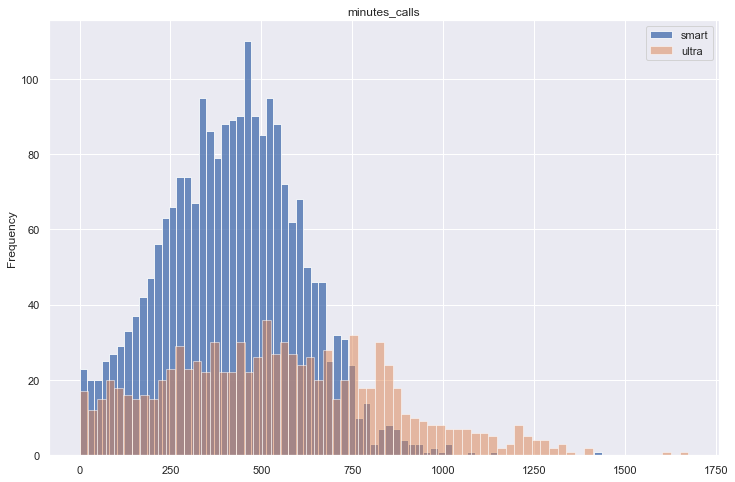

In [57]:
data_merge[data_merge['tariff'] == 'smart']['minutes_calls'].plot(kind='hist', title='minutes_calls', bins=70, alpha=0.8, figsize=(12, 8), label='smart')

data_merge[data_merge['tariff'] == 'ultra']['minutes_calls'].plot(kind='hist', title='minutes_calls', bins=70, alpha=0.5, figsize=(12, 8), label='ultra')

plt.legend()

Гистограмма распределенеия интернет-трафика:

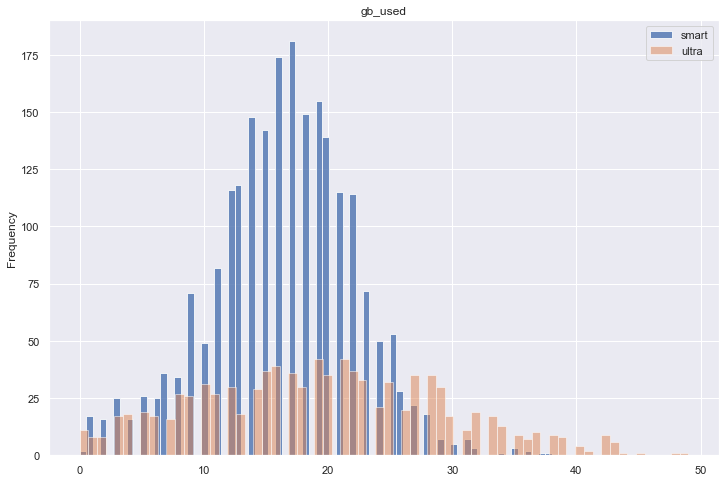

In [58]:
data_merge[data_merge['tariff'] == 'smart']['gb_used'].plot(kind='hist', title='gb_used', bins=70, alpha=0.8, figsize=(12, 8), label='smart')

data_merge[data_merge['tariff'] == 'ultra']['gb_used'].plot(kind='hist', title='gb_used', bins=70, alpha=0.5, figsize=(12, 8), label='ultra')

plt.legend()

Гистограмма распределения сообщений, если отбросить нулевые значения:

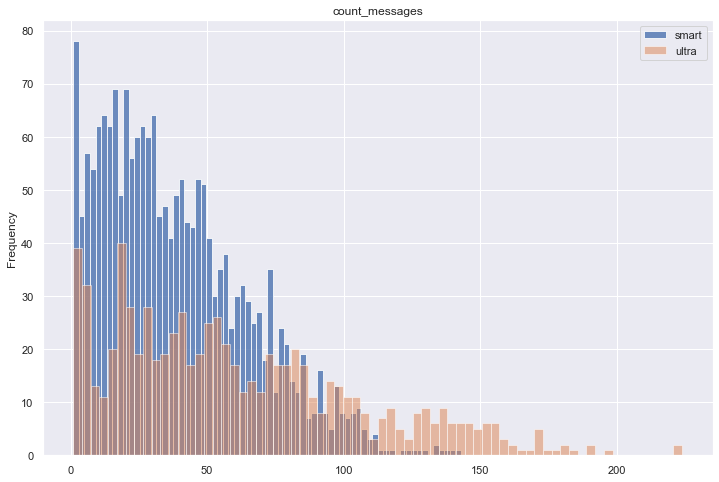

In [59]:
data_merge[(data_merge['tariff'] == 'smart') & (data_merge['count_messages'] > 0)]['count_messages'].plot(kind='hist', bins=70, alpha=0.8, figsize=(12, 8), title='сount_messages', label='smart')

data_merge[(data_merge['tariff'] == 'ultra') & (data_merge['count_messages'] > 0)]['count_messages'].plot(kind='hist', bins=70, alpha=0.5, figsize=(12, 8), title='сount_messages', label='ultra')

plt.legend()

Добавим график по распределению выручки по каждому из тарифов:

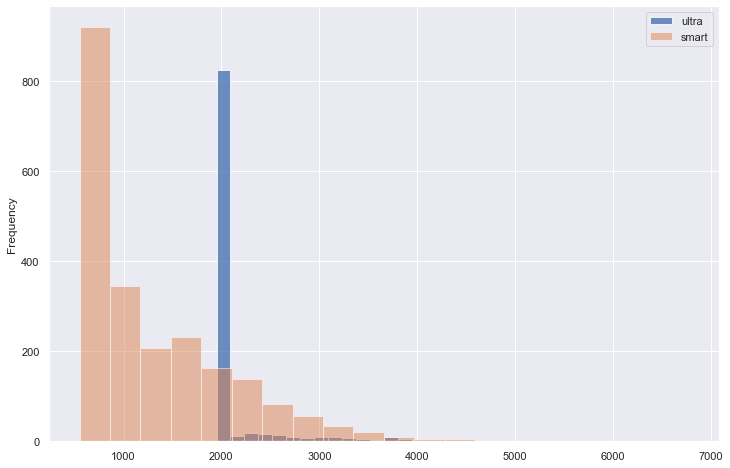

In [60]:
data_merge[(data_merge['tariff'] == 'ultra')]['revenue'].plot(kind='hist', bins=20, alpha=0.8, figsize=(12, 8), label='ultra')

data_merge[(data_merge['tariff'] == 'smart')]['revenue'].plot(kind='hist', bins=20, alpha=0.5, figsize=(12, 8), label='smart')
plt.legend()

**Выводы:**

1. Распределения интернет-трафика являются нормальными с положительными смещениями для обоих тарифов.
2. Распределения для звонков больше похожи на распределения Пуассона.
3. Распределения для сообщений могут иметь большой выброс для нулевого значения. Если отбросить эти значения, то также получим распределение, которое ближе к распределению Пуассона.
4. Пользователи smart в основном потребляют:
    * от 350 до 550 минут;
    * от 12 до 22 гб;
    * до 60 сообщений.
5. Пользователи ultra в основном потребляют:
    * от 250 до 850 минут;
    * от 10 до 30 гб;
    * до 100 сообщений.
6. Распределения выручки говорят о том, что пользователи тарифа смарт чаще выходят за границы пакетов, принося прибыль помимо абонентской платы.

## Проверка гипотез

### Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.

Сформируем нулевую гипотезу - средняя выручка пользователей тарифов "Ультра" и "Смарт" равна.

Альтернативная гипотеза - средняя выручка пользователей тарифов "Ультра" и "Смарт" различна.

Для проверки гипотезы используем scipy.stats.ttest_ind, так как имеем две независимые генеральные совокупности.

In [61]:
alpha = 0.05

result = st.ttest_ind(data_merge[data_merge['tariff'] == 'smart']['revenue'], 
                      data_merge[data_merge['tariff'] == 'ultra']['revenue'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.1830308249112928e-155
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность равенства выручки обоих тарифов стремится к нулю, следовательно нулевая гипотеза не верна - средняя выручка пользователей тарифов «Ультра» и «Смарт» различна.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформируем нулевую гипотезу - средняя выручка пользователей из Москвы и пользователей из других регионов равна.

Альтернативная гипотеза - средняя выручка пользователей из Москвы и пользователей из других регионов различны.

Для проверки гипотезы снова используем scipy.stats.ttest_ind, так как имеем две независимые генеральные совокупности.

In [62]:
alpha = 0.05

result = st.ttest_ind(data_merge.query('city == "Москва"')['revenue'], 
                      data_merge.query('city != "Москва"')['revenue'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4619932225305272
Не получилось отвергнуть нулевую гипотезу


Полученные результаты говорят о том, что, хотя выручка и различна, но с 46 % вероятностью можно получить различие случайно. Это очень большая вероятность. Нулевая гипотеза не может быть отвергнута.

### Какой тариф лучше?

Для ответа на этот вопрос, сформулируем нулевую гипотезу - среднее значение выручки тарифа "Смарт" больше среднего значения выручки "Ультра".

Используем st.ttest_1samp, так как нужно расчитать p-value одной выборки и сравнить его с ожидаемым значением.

In [63]:
mean_smart = data_merge[data_merge['tariff'] == 'smart']['revenue'].mean()

alpha = 0.05

ultra = data_merge[data_merge['tariff'] == 'ultra']['revenue']

results = st.ttest_1samp(ultra, mean_smart)

print('p-значение: ', results.pvalue / 2)

if (results.pvalue / 2 < alpha) and (data_merge[data_merge['tariff'] == 'ultra']['revenue'].mean() > mean_smart):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу


Тариф Ультра определенно лучше.

## Общий вывод:

Для ответа на вопросы по средней выручке пользователей разных тарифов или из разных городов предварительно была произведена обработка исходных датасетов, в каждую таблицу добавлены сведения о тарифах для каждого пользователя.

### Подготовка данных

Во время подготовки данных были произведены следующие изменения:

1. Данные обработаны, даты заменены на объекты datetime.
2. В таблице users вместо пропусков подставлены нули.
3. В таблице calls длительности разговоров были округлены до целого вверх.
4. В таблице internet значения трафика были округлены до целого вверх.
5. Для каждого пользователя посчитаны, по месяцам:
    * количество звонков;
    * количество расходов на звонки;
    * количество расходов на сообщения;
    * количество расходов на интернет-трафик;
    * общая выручка.
6. Расчитанные данные добавлены в одну общую сводную таблицу, которую сгруппировали по месяцам для каждого пользователя.
7. В общей таблице были обработаны nan значения.

### Анализ данных

На этом этапе были совершены следующие действия:

1. Расчитано, сколько минут разговора, сообщений и какой объем трафика требуется пользователям каждого тарифа в месяц.
2. Был произведен расчет среднего количества, дисперсии и стандартное отклонения. 
3. Результаты расчета сведены в общую таблицу.
4. Построены гистограммы минут разговора, сообщений и объема трафика для каждого тарифа.

Распределения были проанализированны и сделаны следующие выводы:

1. Распределения интернет-трафика являются нормальными с положительными смещениями для обоих тарифов.
2. Распределения для звонков больше похожи на распределения Пуассона.
3. Распределения для сообщений могут иметь большой выброс для нулевого значения. Если отбросить эти значения, то также получим распределение, которое ближе к распределению Пуассона.
4. Пользователи smart в основном потребляют:
    * от 350 до 550 минут;
    * от 12 до 22 гб;
    * до 60 сообщений.
5. Пользователи ultra в основном потребляют:
    * от 250 до 850 минут;
    * от 10 до 30 гб;
    * до 100 сообщений.
6. Распределения выручки говорят о том, что пользователи тарифа "Смарт" чаще выходят за границы пакетов.

### Проверка гипотез

На этом этапе были сформулированы и проверены гипотезы о различии выручки в зависимости от тарифа и от города пользователей. Приведены обоснования полученых результатов.

"Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются." - гипотеза подтвердилась.

"Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов." - гипотеза подтвердилась. 

Сделан вывод из расчета t-критерия Стьюдента для среднего одной выборки, что тариф Ультра лучше.